## 간단한 문서에 대해서 서로 간의 문서 유사도를 코사인 유사도 기반으로 구해보자

In [1]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm
    
    return similarity

- doc_list로 정의된 3개의 간단한 문서의 유사도를 비교하기 위해 이 문서를 TF-IDF로 벡터화된 행렬로 변환

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends',
           'if you take the red pill, you stay in Wonderland',
           'if you take the red plll, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 19)


In [7]:
# TfidfVectorizer로 transform()한 결과는 희소 행렬 이므로 밀집 행렬로 변환
feature_vect_dense = feature_vect_simple.todense()

# 첫 번째 문장과 두 번째 문장의 피처 벡터 추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect2 = np.array(feature_vect_dense[1]).reshape(-1, )

# 첫 번째 문장과 두 번째 문장의 피처 벡터로 두 개 문장의 코사인 유사도 추출
similarity_simple = cos_similarity(vect1, vect2)
print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 Cosine 유사도: 0.424


In [8]:
# 첫 번째 문장과 세 번째 문장, 그리고 두 번째 문장과 세 번째 문장의 유사도 측정
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )
similarity_simple = cos_similarity(vect1, vect3)
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )
similarity_simple = cos_similarity(vect2, vect3)
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.342
문장 2, 문장 3 Cosine 유사도: 0.394


- 사이킷런은 코사인 유사도를 측정하기 위해 **`sklearn.metrics.pairwise.cosine_similarity`** API를 제공
- 이번엔 이를 이용해 앞 예제의 문서 유사도를 측정해 보자
- cosine_similarity() 함수는 두 개의 입력 파라미터 받음
    - 첫 번째 파라미터: 비교 기준이 되는 문서의 피처 행렬
    - 두 번째 파라미터: 비교되는 문서의 피처 행렬

- 첫 번째 문서와 비교해 바로 자신 문서인 첫 번째 문서, 두 번째, 세 번째 문서의 유사도 측정

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity_simple_pair)

# 만일 1이라는 값이 거슬린다면 다음과 같이 비교 대상에서 feature_vect[1:]을 이용해 비교 기준 문서 제외
#similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple[1:])
#print(similarity_simple_pair)

[[1.         0.42384035 0.34189038]]


- 첫 번째 유사도 값인 1은 비교 기준인 첫 번째 문서 자신에 대한 유사도 측정
- 두 번째 유사도 값인 0.42384035는 첫 번째 문서와 두 번째 문서의 유사도
- 0.34189038은 첫 번째 문서와 세 번째 문서의 유사도 값

cosine_similarity()는 쌍으로(pair) 코사인 유사도 값 제공할 수 있음

모든 개별 문서에 쌍으로 코사인 유사도 값을 계산해 보자

In [11]:
similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print('shape:', similarity_simple_pair.shape)

[[1.         0.42384035 0.34189038]
 [0.42384035 1.         0.39424779]
 [0.34189038 0.39424779 1.        ]]
shape: (3, 3)


## Opinion Review 데이터 세트를 이용한 문서 유사도 측정

In [14]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.stem import WordNetLemmatizer
import nltk
import string

path = 'C:/Users/영현/Desktop/OpinosisDataset1.0/topics'
all_files = glob.glob(os.path.join(path, '*data'))
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())


remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))    


document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                            ngram_range=(1,2), min_df=0.05, max_df=0.85)

feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

C:\Users\hyun\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [16]:
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

- 이전 절에서 해당 문서의 군집화는 전자제품, 호텔, 자동차를 주제로 군집화됐음
- 이 중 호텔은 주제로 군집화된 문서를 이용해 특정 문서와 다른 문서 간의 유사도를 알아보자
- 문서를 피처 벡터화해 변환하면 문서 내 단어(Word)에 출현 빈도와 같은 값을 부여해 각 문서가 단어 피처의 값으로 벡터화 됨
- 이렇게 각 문서가 피처 벡터화된 데이터를 cosine_similarity()를 이용해 상호 비교해 유사도를 확인해보자

- 먼저 이를 위해 호텔을 주제로 군집화된 데이터를 먼저 추출하고, 이 데이터에 해당하는 TfidfVectorizer의 데이터를 추출
- 호텔 군집화 데이터를 기반으로 별도의 TF-IDF 벡터화를 수행하지 않고, 바로 위에서 TfidfVectorizer로 만들어진 데이터에서 그대로 추출하겠음

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=1인 데이터는 호텔로 군집화된 데이터임
hotel_indexes = document_df[document_df['cluster_label']==1].index
print('호텔로 군집화 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 군집화된 데이터 중 첫 번째 문서를 추출해 파일명 표시
comparision_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명 ', comparision_docname, '와 타 문서 유사도 #####')

'''document_df에서 추출한 Index 객체를 feature_vect로 입력해 호텔 군집화된 feature_vect 추출
이를 이용해 호텔로 군집화된 문서 중 첫 번째 문서와 다른 문서 간의 코사인 유사도 측정'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 군집화 된 문서들의 DataFrame Index: Int64Index([1, 13, 14, 15, 20, 21, 24, 28, 30, 31, 32, 38, 39, 40, 45, 46], dtype='int64')
##### 비교 기준 문서명  bathroom_bestwestern_hotel_sfo 와 타 문서 유사도 #####
[[1.         0.05907195 0.05404862 0.03739629 0.06629355 0.06734556
  0.04017338 0.13113702 0.41011101 0.3871916  0.57253197 0.10600704
  0.13058128 0.1602411  0.05539602 0.05839754]]


- 단순히 숫자로만 표시해서는 직관적으로 문서가 어느 정도 유사도를 가지는지 이해하기 어려움
- 첫 번째 문서와 다른 문서 간에 유사도가 높은 순으로 이를 정렬하고 시각화해 보자
- cosine_similarity()는 쌍 형태의 ndarray를 반환하므로 이를 판다스 인덱스로 이용하기 위해 reshape(-1)로 차원 변경

Text(0.5, 1.0, 'bathroom_bestwestern_hotel_sfo')

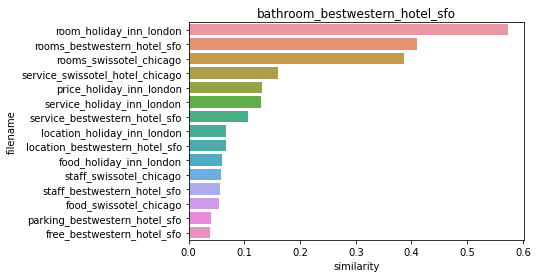

In [28]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 첫 번째 문서와 타 문서 간 유사도가 큰 순으로 정렬한 인덱스를 추출하되 자기 자신은 제외
sorted_index = similarity_pair.argsort()[:, ::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출해 재정령
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도 값을 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.title(comparision_docname)

- 첫 번째 문서인 샌프란시스코의 베스트 웨스턴 호텔 화장실 리뷰(Best Western Hotel Bathroom Review)인 bathroom_bestwestern_hotel_sfo와 가장 비슷한 문서는 room_holiday_inn_london으로 약 0.572인 코사인 유사도 값